In [1]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as nc
from gi.repository import NumCosmoMath as ncm
import numpy as np
import sys
sys.path.insert(0,'../../scripts')

from scipy.stats import chi2
import corner

import pyccl as ccl
from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec

ncm.cfg_init()
ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
s1d1 = chi2.cdf (1.0, df = 1)
s1d2 = chi2.cdf (4.0, df = 1)
s2d1 = chi2.cdf (1.0, df = 1)
s2d2 = chi2.cdf (4.0, df = 1)
s2d3 = chi2.cdf (9.0, df = 1)
qts = [0.5 - s1d2 / 2.0, 0.5 - s1d1 / 2.0, 0.5, 0.5 + s1d1 / 2.0, 0.5 + s1d2 / 2.0]

In [3]:
from chainconsumer import ChainConsumer

def add_mcat(c, mcat, name):
    nwalkers = mcat.nchains ()
    m2lnL = mcat.get_m2lnp_var ()

    # Use nwalkers * 10 as burning length
    burn = nwalkers * burnin
    rows = np.array ([mcat.peek_row (i).dup_array () for i in range (burn, mcat.len ())])
    params = ["$" + mcat.col_symb (i) + "$" for i in range (mcat.ncols ())]

    posterior = -0.5 * rows[:,m2lnL]

    rows   = np.delete (rows,   m2lnL, 1)
    params = np.delete (params, m2lnL, 0)

    indices = [0,1,2]

    rows   = rows[:,indices]
    params = params[indices]

    c.add_chain(rows, posterior = posterior, parameters=list(params), name=name)

In [4]:
nwalkers = 300
burnin   = 80

mcat_mcmc_unbinned = Ncm.MSetCatalog.new_from_file_ro ("ncount_ascaso_mcmc_unbinned.fits", nwalkers * burnin)
mcat_mcmc_binned = Ncm.MSetCatalog.new_from_file_ro ("ncount_ascaso_mcmc_binned.fits",   nwalkers * burnin)

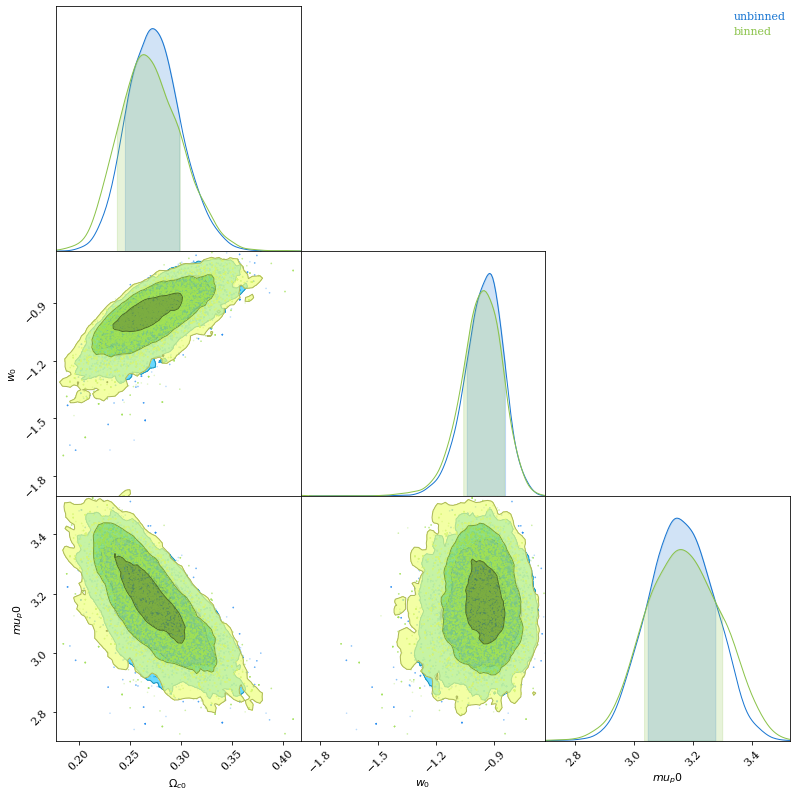

In [5]:
consumer = ChainConsumer()
    
add_mcat (consumer, mcat_mcmc_unbinned, "unbinned")
add_mcat (consumer, mcat_mcmc_binned, "binned")

consumer.configure (kde = True, label_font_size=11, cloud=True, sigma2d=True, sigmas = [1, 2, 3], spacing = 0.0, tick_font_size=11, usetex=False)

fig = consumer.plotter.plot()

fig.set_size_inches(12, 12)

In [6]:
nwalkers = 300
burnin   = 0

mcat_mc_unbinned = Ncm.MSetCatalog.new_from_file_ro ("ncount_ascaso_mc_unbinned.fits", nwalkers * burnin)
mcat_mc_binned = Ncm.MSetCatalog.new_from_file_ro ("ncount_ascaso_mc_binned.fits",   nwalkers * burnin)

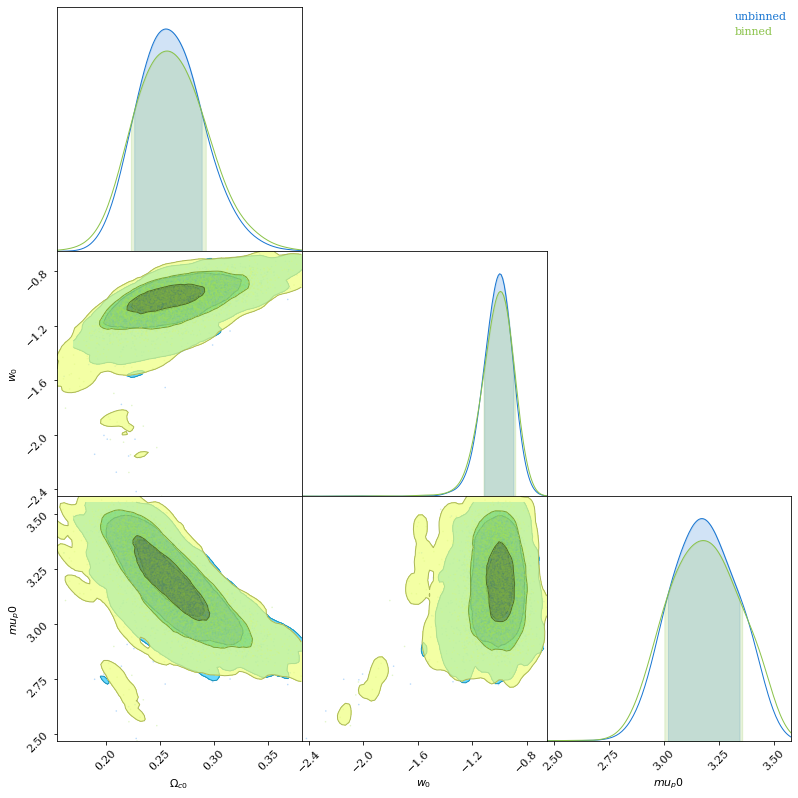

In [7]:
consumer = ChainConsumer()
    
add_mcat (consumer, mcat_mc_unbinned, "unbinned")
add_mcat (consumer, mcat_mc_binned, "binned")

consumer.configure (kde = True, label_font_size=11, cloud=True, sigma2d=True, sigmas = [1, 2, 3], spacing = 0.0, tick_font_size=11, usetex=False)

fig = consumer.plotter.plot()

fig.set_size_inches(12, 12)

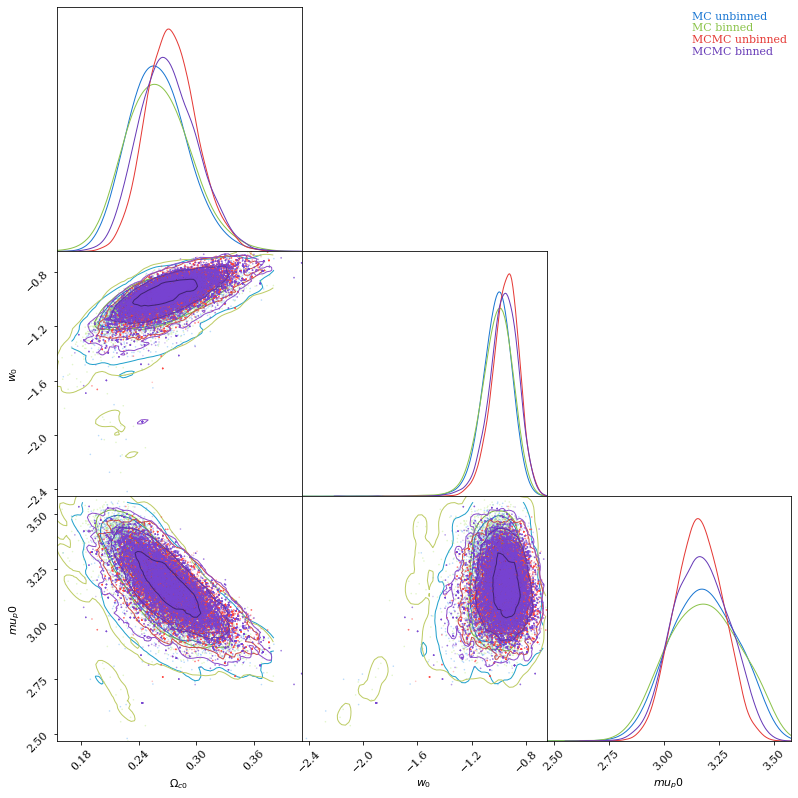

In [8]:
consumer = ChainConsumer()
    
add_mcat (consumer, mcat_mc_unbinned, "MC unbinned")
add_mcat (consumer, mcat_mc_binned, "MC binned")
add_mcat (consumer, mcat_mcmc_unbinned, "MCMC unbinned")
add_mcat (consumer, mcat_mcmc_binned, "MCMC binned")

consumer.configure (kde = True, label_font_size=11, cloud=True, sigma2d=True, sigmas = [1, 2, 3], spacing = 0.0, tick_font_size=11, usetex=False)

fig = consumer.plotter.plot()

fig.set_size_inches(12, 12)

In [9]:
def measure_over_smooth (mcat):
    mcat_len = mcat.len ()
    nwalkers = mcat.nchains ()
    last_e = [mcat.peek_row (mcat_len - nwalkers + i) for i in range (nwalkers)]
    k = Ncm.StatsDistKernelST.new (3, 1.0)
    sd = Ncm.StatsDistVKDE.new (k, Ncm.StatsDistCV.SPLIT)
    sd.reset ()
    m2lnL = []
    for row in last_e:
        m2lnL.append (row.get (0))
        sd.add_obs (row.get_subvector (1, 3))

    m2lnL_v = Ncm.Vector.new_array (m2lnL)
    sd.prepare_interp (m2lnL_v)
    return sd.get_over_smooth ()

In [10]:
print (measure_over_smooth (mcat_mcmc_unbinned))
print (measure_over_smooth (mcat_mcmc_binned))

0.3664704025054064
0.3940186484859218
